### Revisions
1. use merge_asof to match the forecast date to the dates in the rate table
2. filter the meter aq so it’s in between the min aq and max aq in the rate table
3. (Optional) Graphs to show linear

In [189]:
import pandas as pd

#retrieve csv
def read_csv(path):
    return pd.read_csv(path)

def format_value(x):
    if isinstance(x, (int, float)):
        return f"{x:.2f}"
    return x

def calc_cost(rates, meters, forecast):
    # Merge the meters and rates table
    df_mr = pd.merge(meters, rates, on='exit_zone')
    
    # Convert dates to datetime
    df_mr['date'] = pd.to_datetime(df_mr['date'])
    forecast['date'] = pd.to_datetime(forecast['date'])
    
    # Sort values by date for asof merge
    df_mr = df_mr.sort_values(by='date')
    forecast = forecast.sort_values(by='date')
    
    # Merge meters-rates with forecast
    df = pd.merge_asof(df_mr, forecast, by='meter_id', on='date', direction='nearest')
    filtered_aq = df[(df['aq_kwh'] >= df['aq_min_kwh']) & (df['aq_kwh'] <= df['aq_max_kwh'])].copy()

    # Calculate the daily charge
    filtered_aq['daily_charge'] = filtered_aq['rate_p_per_kwh'] * filtered_aq['kwh']
    
    # Calculate the total cost and forecast
    cost_total = filtered_aq.groupby('meter_id')['daily_charge'].sum() * 0.01
    forecast_total = filtered_aq.groupby('meter_id')['kwh'].sum()
    
    # Create one table, reset the index as it's registering meter_id as the index due to previous groupby
    df_total = pd.merge(forecast_total, cost_total, on='meter_id').reset_index()
    
    # Making it pretty now
    columns = {
        'meter_id': 'Meter ID', 
        'kwh': 'Total Estimated Consumption (kWh)', 
        'daily_charge': 'Total Cost (£)'
    }
    df_total['kwh'] = df_total['kwh'].map(format_value)
    df_total['daily_charge'] = df_total['daily_charge'].map(format_value)
    
    df_result = df_total.rename(columns=columns)
    
    # Display the result
    return df_result

rates = read_csv("./data/rate.csv")
meters = read_csv("./data/meter.csv")
forecast = read_csv("./data/forecast.csv")

calc_cost(rates, meters, forecast)

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,369.89,1.76
1,34509937,930.50,4.40
2,50264822,3458.30,13.07
3,88357331,5140.55,20.44


In [152]:
def gen_meter_list(m, ez, seed, min_aq=0, max_aq=5000):
    meter_ids = np.random.randint(1, int(1e7), size=m)
    exit_zones = np.random.choice(ez, size=m) 
    annual_quantity = np.random.uniform(min_aq, max_aq, size=m)

    data = {
        'meter_id': meter_ids,
        "exit_zone": exit_zones,
        'aq_kwh': annual_quantity
    }

    df_meters = pd.DataFrame(data)
    return df_meters

In [153]:
def gen_consumption_list(meter_list, start_date, periods):
    # make sure start date is in the correct format using Panda Datetime stamp
    if isinstance(start_date, str):
        start_date = pd.Timestamp(start_date)
    else:
        raise TypeError("Start Date must be a string and a valid date YYYY-MM-DD format.")

    # generate forecast periods using duration by Day
    dates = pd.date_range(start=start_date, periods=periods, freq='D')
    # get generated meter list (meter_id, dates, kwh)
    meters = meter_list['meter_id'].values    
    # print(meters, len(dates), len(consumption))

    # get consumption data
    df_consumption = pd.DataFrame({
        'meter_id': np.random.choice(meters, size=periods * len(meters)),
        'date': np.tile(dates, len(meters)),
        'kwh': np.random.randint(10, 100, size=periods * len(meters))
    })
    
    return df_consumption

In [190]:
ez = rates['exit_zone'].unique() # this is just to get only unique exit zones in existing data.
m = gen_meter_list(len(ez),ez)
c = gen_consumption_list(m, '2024-01-01', 30)

calc_cost(rates,m,c)

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,62942,254.00,1.08
1,153054,416.00,2.11
2,602559,900.00,3.54
3,1160343,756.00,2.91
4,1531209,714.00,2.58
5,1840494,932.00,4.20
6,2209749,328.00,1.26
7,2822209,364.00,1.60
8,3145936,300.00,1.80
9,3464374,774.00,2.70


In [201]:
import timeit
import pandas as pd
import numpy as np
from memory_profiler import memory_usage

def benchmark(fn, size, seed=42, days=30):
    m = gen_meter_list(size, ez, seed)
    c = gen_consumption_list(m, '2024-01-01', days)
    rates = read_csv("./data/rate.csv")

    # execution time
    exe_time = timeit.timeit(lambda: fn(rates,m,c), number=10)
    avg_time = exe_time / 10

    # memory usage
    mem = memory_usage((calc_cost, (rates, m, c)), max_iterations=1)
    avg_mem = max(mem) - min(mem)

    return avg_time, avg_mem

# testing the test
def benchmark_test(fn):
    sizes = [100, 1000, 10000, 100000, 500000, 1000000]
    results = []
    
    for size in sizes:
        runtime, mem_usage = benchmark(fn, size)
        results.append([size, runtime, mem_usage])
        print(f"Size: {size}, Avg Runtime: {runtime:.2f} seconds, Memory Usage: {mem_usage:.2f} MiB")

    return results

matrix = benchmark_test(calc_cost)

Size: 100, Avg Runtime: 0.01 seconds, Memory Usage: 37.70 MiB
Size: 1000, Avg Runtime: 0.02 seconds, Memory Usage: 35.00 MiB
Size: 10000, Avg Runtime: 0.13 seconds, Memory Usage: 70.02 MiB
Size: 100000, Avg Runtime: 1.39 seconds, Memory Usage: 8.59 MiB
Size: 500000, Avg Runtime: 8.46 seconds, Memory Usage: 332.34 MiB
Size: 1000000, Avg Runtime: 18.31 seconds, Memory Usage: 990.86 MiB
[[100, 0.007189758399908897, 37.703125], [1000, 0.015861779099941485, 35.0], [10000, 0.13480562920012745, 70.015625], [100000, 1.3891990249998343, 8.59375], [500000, 8.46419695000004, 332.34375], [1000000, 18.305314320899924, 990.859375]]


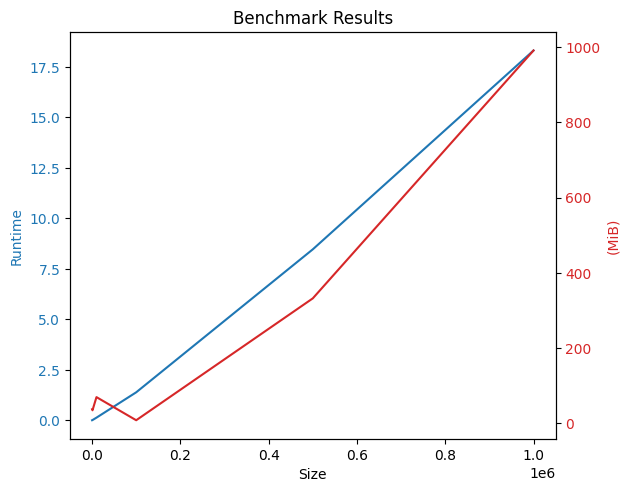

In [203]:
import matplotlib.pyplot as plt

def plot_benchmark_results(matrix):
    sizes = [row[0] for row in matrix]
    runtimes = [row[1] for row in matrix]
    mem_usages = [row[2] for row in matrix]
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Size')
    ax1.set_ylabel('Runtime', color=color)
    ax1.plot(sizes, runtimes, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('(MiB)', color=color)
    ax2.plot(sizes, mem_usages, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Benchmark Results')
    plt.show()

# Plot the results
plot_benchmark_results(matrix)

In [205]:
import dask.dataframe as dd

def combine_df_dask(rates, meters, forecast):
    # Merge the meters and rates table
    df_mr = meters.merge(rates, on='exit_zone')
    
    # Convert dates to datetime
    df_mr['date'] = dd.to_datetime(df_mr['date'])
    forecast['date'] = dd.to_datetime(forecast['date'])
    
    # Sort values by date for asof merge
    df_mr = df_mr.sort_values(by='date')
    forecast = forecast.sort_values(by='date')
    
    # Merge meters-rates with forecast
    df_mrf = dd.merge_asof(df_mr, forecast, by='meter_id', on='date', direction='nearest')

    return df_mrf

def calc_cost_dask (m,c):
    meter_dask = dd.from_pandas(m, npartitions=4)
    consumption_dask = dd.from_pandas(c, npartitions=4)

    df = combine_df_dask(rates, meter_dask, consumption_dask)
    filtered_df(df)

# Run benchmark for Dask function